In [1]:
import torch 
import torch.nn as nn
import numpy as np
import pandas as pd
from sklearn.preprocessing import LabelEncoder


## Methode 1:

In [2]:
class encoder(nn.Module):
    def __init__(self, input_size=21, hidden1=256, hidden2=128, output_size=64):
        super().__init__()
        #aka a simple mlp
        self.fc1=nn.Linear(input_size,hidden1)
        self.fc2=nn.Linear(hidden1,hidden2)
        self.fc3=nn.Linear(hidden2,output_size)
        self.act=nn.ReLU()
    def forward(self,x):
        x=self.fc1(x)
        x=self.fc2(self.act(x))
        return self.fc3(x)
# Projector: small MLP
def projector_fn(input_dim=64, proj_dim=128, hidden_dim=256):
    return nn.Sequential(
        nn.Linear(input_dim, hidden_dim),
        nn.BatchNorm1d(hidden_dim),
        nn.ReLU(),
        nn.Linear(hidden_dim, proj_dim)
    )

# Predictor: small MLP (only online network has this)
def predictor_fn(proj_dim=128, hidden_dim=256):
    return nn.Sequential(
        nn.Linear(proj_dim, hidden_dim),
        nn.BatchNorm1d(hidden_dim),
        nn.ReLU(),
        nn.Linear(hidden_dim, proj_dim)
    )

class Online(nn.Module):
    def __init__(self,input_size=21,hidden_size=256,output_size=64,proj_dim=128):
        super().__init__()
        self.encoder=encoder(input_size=input_size, hidden1=hidden_size, hidden2=128, output_size=output_size)
        self.projector = projector_fn(output_size, proj_dim)
        self.predictor = predictor_fn(proj_dim)
    def forward(self,x,return_features=False):
        h=self.encoder(x)
        z=self.projector(h)
        p=self.predictor(z)
        if return_features:
            return h
        return z,p
class Target(nn.Module):
    def __init__(self,input_size=21,hidden_size=256,output_size=64,proj_dim=128):
        super().__init__()
        self.encoder=encoder(input_size=input_size, hidden1=hidden_size, hidden2=128, output_size=output_size)
        self.projector = projector_fn(output_size, proj_dim)
    def forward(self,x):
        x=self.encoder(x)
        x=self.projector(x)
        return x
        
        
        

### dataset processig

In [3]:
data=pd.read_csv("/kaggle/input/ctu-13/CTU_13.csv")
data

/tmp/ipykernel_36/848530726.py:1: DtypeWarning: Columns (5) have mixed types. Specify dtype option on import or set low_memory=False.
  data=pd.read_csv("/kaggle/input/ctu-13/CTU_13.csv")
/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1458: RuntimeWarning: invalid value encountered in greater
  has_large_values = (abs_vals > 1e6).any()
/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in less
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()
/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in greater
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()


,Unnamed: 0,StartTime,Dur,Proto,SrcAddr,Sport,Dir,DstAddr,Dport,State,sTos,dTos,TotPkts,TotBytes,SrcBytes,Label
0,0,2011/08/10 09:46:59.607825,1.026539,tcp,94.44.127.113,1577,->,147.32.84.59,6881,S_RA,0.0,0.0,4,276,156,flow=Background-Established-cmpgw-CVUT
1,1,2011/08/10 09:47:00.634364,1.009595,tcp,94.44.127.113,1577,->,147.32.84.59,6881,S_RA,0.0,0.0,4,276,156,flow=Background-Established-cmpgw-CVUT
2,2,2011/08/10 09:47:48.185538,3.056586,tcp,147.32.86.89,4768,->,77.75.73.33,80,SR_A,0.0,0.0,3,182,122,flow=Background-TCP-Attempt
3,3,2011/08/10 09:47:48.230897,3.111769,tcp,147.32.86.89,4788,->,77.75.73.33,80,SR_A,0.0,0.0,3,182,122,flow=Background-TCP-Attempt
4,4,2011/08/10 09:47:48.963351,3.083411,tcp,147.32.86.89,4850,->,77.75.73.33,80,SR_A,0.0,0.0,3,182,122,flow=Background-TCP-Attempt
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19976678,19976695,2011/08/16 09:36:00.710103,0.000000,udp,147.32.84.229,13363,->,125.14.162.10,27460,INT,0.0,NaN,1,476,476,flow=Background-UDP-Attempt
19976679,19976696,2011/08/16 09:36:00.777160,0.000427,udp,213.146.167.54,20856,<->,147.32.84.229,13363,CON,0.0,0.0,2,135,75,flow=Background-UDP-Established
19976680,19976697,2011/08/16 09:36:00.784094,0.000000,udp,147.32.84.229,13363,->,122.121.0.92,12923,INT,0.0,NaN,1,476,476,flow=Background-UDP-Attempt
19976681,19976698,2011/08/16 09:36:00.784160,0.000000,udp,147.32.84.229,13363,->,110.233.175.133,37690,INT,0.0,NaN,1,476,476,flow=Background-UDP-Attempt


In [4]:
le = LabelEncoder()

lst = []
for i in data['Label']:
        if 'Botnet' in i:
            lst.append(1)
        elif 'Normal' in i:
            lst.append(2)
        else:
            lst.append(0)
    
data['Label']=lst

In [5]:
data=data[data['Label']!=0]
direction_number = []
for i in data['Dir']:
        if i == '  <->':
            direction_number.append(1)
        elif i == '   ->':
            direction_number.append(2)
        else:
            direction_number.append(0)

In [6]:
data['Dir'] = direction_number
dataset=data.drop(columns=['Unnamed: 0'],inplace=False)
dataset.dropna(inplace=True)

/tmp/ipykernel_36/4101091453.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Dir'] = direction_number


In [7]:
dt = pd.to_datetime(dataset['StartTime'], format='%Y/%m/%d %H:%M:%S.%f')
df = pd.DataFrame({'datetime': dt})
dataset['year'] = df['datetime'].dt.year
dataset['month'] = df['datetime'].dt.month
dataset['day'] = df['datetime'].dt.day
dataset['hour'] = df['datetime'].dt.hour
dataset['minute'] = df['datetime'].dt.minute
dataset['second'] = df['datetime'].dt.second
dataset['dayofweek'] = df['datetime'].dt.dayofweek  # Monday=0, Sunday=6
dataset['is_weekend'] = dataset['dayofweek'].isin([5,6]).astype(int)
dataset.drop(columns=['StartTime'],inplace=True)

In [8]:
cat_cols=['Proto','SrcAddr','DstAddr','Dport','State']
for col in cat_cols:
        numeric_labels = le.fit_transform(dataset[col])
        dataset[col]=numeric_labels

In [9]:
numeric_labels = le.fit_transform(dataset['Sport'].astype('str'))
dataset['Sport']=numeric_labels
total_len = len(dataset)

In [10]:
datasetlabeled=dataset.copy()
dataset.drop(columns=['Label'],inplace=True)
# 80% for encoder (unlabeled)
encoder_data = dataset[:int(total_len * 0.8)]
# Next 10% for linear classifier training (labeled)
lineardata = datasetlabeled[int(total_len * 0.8):int(total_len * 0.9)]
# Final 10% for evaluation (labeled)

In [11]:
datasetevaluation = datasetlabeled[int(total_len * 0.9):]

In [12]:
def nt_xent_loss(z1, z2, temperature=0.5):
    """
    Normalized Temperature-scaled Cross Entropy Loss (NT-Xent) for SimCLR.
    """
    batch_size = z1.size(0)

    z1 = F.normalize(z1, dim=1)
    z2 = F.normalize(z2, dim=1)

    z = torch.cat([z1, z2], dim=0)  # (2N, dim)

    # Cosine similarity matrix
    sim_matrix = F.cosine_similarity(z.unsqueeze(1), z.unsqueeze(0), dim=2)  # (2N, 2N)

    # Mask self-similarities
    mask = torch.eye(2 * batch_size, dtype=torch.bool).to(z.device)
    sim_matrix = sim_matrix[~mask].view(2 * batch_size, -1)

    # Positive pair indices: for i in [0, N-1], positive is i+N; for i in [N, 2N-1], positive is i-N
    positives = torch.cat([torch.arange(batch_size, 2*batch_size),
                           torch.arange(0, batch_size)]).to(z.device)

    # Similarities for positives
    pos_sim = torch.cat([F.cosine_similarity(z1, z2),
                         F.cosine_similarity(z2, z1)])

    # Numerator: exp(sim(pos)/T), Denominator: sum over all others
    numerator = torch.exp(pos_sim / temperature)
    denominator = torch.sum(torch.exp(sim_matrix / temperature), dim=1)

    loss = -torch.log(numerator / denominator)
    return loss.mean()


In [48]:
def cossim(p, z, alpha=0.5, temperature=0.5):
    # BYOL loss (negative cosine similarity)
    p = F.normalize(p, dim=-1)
    z = F.normalize(z, dim=-1)
    byol = -(p * z).sum(dim=-1).mean()
    return byol

In [13]:
def hybrid_loss(p, z, alpha=0.5, temperature=0.5):
    # BYOL loss (negative cosine similarity)
    p = F.normalize(p, dim=-1)
    z = F.normalize(z, dim=-1)
    byol = -(p * z).sum(dim=-1).mean()

    # SimCLR NT-Xent loss
    simclr = nt_xent_loss(p, z, temperature=temperature)

    # Combined
    return alpha * byol + (1 - alpha) * simclr


In [14]:
#got bless the inplace=False 

### proc data for training (dataloadre +other stuff)

In [15]:
def augment(x, mask_rate=0.1, noise_std=0.1):
    """
    x: torch.Tensor [batch, features]
    """
    augmented = x.clone()

    if mask_rate > 0:
        mask = torch.rand_like(augmented) < mask_rate
        col_means = augmented.mean(dim=0, keepdim=True)   # per feature mean
        augmented[mask] = col_means.expand_as(augmented)[mask]

    if noise_std > 0:
        noise = torch.randn_like(augmented) * noise_std
        augmented = augmented + noise

  
    return augmented

In [16]:
import torch
from torch.utils.data import DataLoader,TensorDataset
print(type(encoder_data),dataset.shape)

<class 'pandas.core.frame.DataFrame'> (563790, 21)


In [17]:
X_tensor = torch.tensor(encoder_data.values, dtype=torch.float32) 

In [18]:
flow_dataset = TensorDataset(X_tensor) 

In [19]:
dataloader = DataLoader(flow_dataset, batch_size=256, shuffle=True)


In [20]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


In [21]:
onlinenn=Online().to(device)
targetnn=Target().to(device)

In [22]:
optimizeronline = torch.optim.Adam(list(onlinenn.parameters()) , lr=1e-3)
 

In [23]:
@torch.no_grad()
def update_target(online, target, m=0.99):  # momentum = 0.99
    for param_o, param_t in zip(online.parameters(), target.parameters()):
        param_t.data = m * param_t.data + (1 - m) * param_o.data

In [24]:
#cause the target is updated by exponential not grad decoence


In [25]:
import torch.nn.functional as F


### methode 1: just update the loss function differenctly

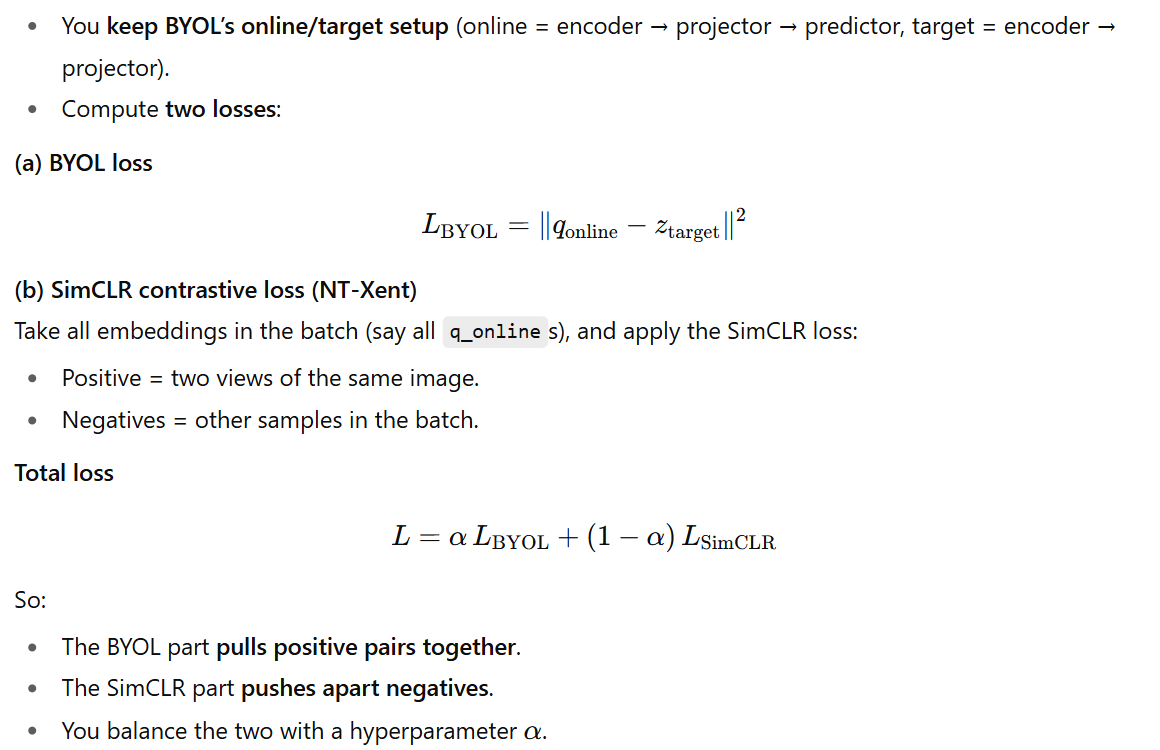

In [26]:
epochs=20
for epoch in range(epochs):
    totalloss=0
    for batch in dataloader:
        batchdata=batch[0].to(device)

        x1, x2 = augment(batchdata), augment(batchdata)
        
        z1, p1 = onlinenn(x1)
        z2, p2 = onlinenn(x2)
        t1 = targetnn(x1)
        t2 = targetnn(x2)
        
        loss = hybrid_loss(p1, t2) + hybrid_loss(p2, t1)
        
        optimizeronline.zero_grad()
        loss.backward()
        optimizeronline.step()
        update_target(onlinenn, targetnn)
        totalloss+=loss
    avgloss=totalloss/(len(dataloader))
    print(f"Epoch {epoch+1} loss {avgloss}")


Epoch 1 loss 4.672091007232666
Epoch 2 loss 4.601657390594482
Epoch 3 loss 4.544620990753174
Epoch 4 loss 4.468493461608887
Epoch 5 loss 4.394194602966309
Epoch 6 loss 4.338400363922119
Epoch 7 loss 4.333273887634277
Epoch 8 loss 4.327513217926025
Epoch 9 loss 4.371735095977783
Epoch 10 loss 4.345101833343506
Epoch 11 loss 4.329475402832031
Epoch 12 loss 4.328156471252441
Epoch 13 loss 4.322437286376953
Epoch 14 loss 4.344583034515381
Epoch 15 loss 4.330702304840088
Epoch 16 loss 4.315807819366455
Epoch 17 loss 4.354662895202637
Epoch 18 loss 4.340075969696045
Epoch 19 loss 4.349849224090576
Epoch 20 loss 4.334446907043457


### da linear class

In [27]:
import torch.nn as nn

embedding_dim = 64  
num_classes = 2  
linear_classifier = nn.Linear(embedding_dim, num_classes)

In [28]:
X_labeled=lineardata.drop(columns=['Label'],inplace=False)
y_labels=lineardata['Label']

In [29]:
y_labels.unique() #the 1 2 wont work with crossentrloss

array([1, 2])

In [30]:
y_labels = torch.tensor(y_labels.values, dtype=torch.long)


In [31]:
unique_labels = torch.unique(y_labels)
label_map = {old.item(): new for new, old in enumerate(unique_labels)}
y_labels = torch.tensor([label_map[int(l)] for l in y_labels], dtype=torch.long)

In [32]:
X_tensor = torch.tensor(X_labeled.values, dtype=torch.float32).to(device)
#y_tensor = torch.tensor(y_labels.values, dtype=torch.long).to(device)

In [33]:
with torch.no_grad():
    embeddings = onlinenn(X_tensor,True)

In [34]:
def makedataloadder(dataset):#for the dataset with label
        X_labeled=dataset.drop(columns=['Label'],inplace=False)
        y_labels=dataset['Label']
        y_labels = torch.tensor(y_labels.values, dtype=torch.long)
        unique_labels = torch.unique(y_labels)
        label_map = {old.item(): new for new, old in enumerate(unique_labels)}
        y_labels = torch.tensor([label_map[int(l)] for l in y_labels], dtype=torch.long)
        X_tensor = torch.tensor(X_labeled.values, dtype=torch.float32).to(device)
        with torch.no_grad():
            embeddings = encoder(X_tensor)
        clf_dataset = TensorDataset(embeddings, y_labels)
        clf_loader = DataLoader(clf_dataset, batch_size=256, shuffle=True)
        return clf_loader



In [35]:
clf_dataset = TensorDataset(embeddings, y_labels)
clf_loader = DataLoader(clf_dataset, batch_size=256, shuffle=True)


In [36]:

# Linear classifier
classifier = nn.Linear(embeddings.shape[1], len(unique_labels))
classifier = classifier.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(classifier.parameters(), lr=1e-3)

# Training loop
for epoch in range(20):
    total_loss = 0
    for xb, yb in clf_loader:
        xb, yb = xb.to(device), yb.to(device)

        optimizer.zero_grad()
        preds = classifier(xb)
        loss = criterion(preds, yb)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()
    print(f"Epoch {epoch+1}, Loss: {total_loss / len(clf_loader):.4f}")

Epoch 1, Loss: 1260.5728
Epoch 2, Loss: 982.7978
Epoch 3, Loss: 392.5366
Epoch 4, Loss: 239.8320
Epoch 5, Loss: 284.9058
Epoch 6, Loss: 127.4377
Epoch 7, Loss: 321.0350
Epoch 8, Loss: 1340.1505
Epoch 9, Loss: 554.8067
Epoch 10, Loss: 122.8026
Epoch 11, Loss: 587.0304
Epoch 12, Loss: 313.3304
Epoch 13, Loss: 450.4193
Epoch 14, Loss: 1347.3938
Epoch 15, Loss: 481.7696
Epoch 16, Loss: 124.8338
Epoch 17, Loss: 554.7603
Epoch 18, Loss: 493.1891
Epoch 19, Loss: 258.1800
Epoch 20, Loss: 300.8521


In [37]:
datasetevaluation

,Dur,Proto,SrcAddr,Sport,Dir,DstAddr,Dport,State,sTos,dTos,...,SrcBytes,Label,year,month,day,hour,minute,second,dayofweek,is_weekend
18322351,0.189872,3,7,2834,1,1366,752,4,0.0,0.0,...,74,1,2011,8,15,18,47,41,0,0
18322356,0.189283,3,7,7717,1,1366,752,4,0.0,0.0,...,69,1,2011,8,15,18,47,41,0,0
18322408,0.030104,3,8,34660,1,1366,752,4,0.0,0.0,...,82,2,2011,8,15,18,47,41,0,0
18322409,0.000234,3,8,19210,1,1366,752,4,0.0,0.0,...,82,2,2011,8,15,18,47,41,0,0
18322410,0.000239,3,8,26579,1,1366,752,4,0.0,0.0,...,82,2,2011,8,15,18,47,41,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19975942,0.000429,3,8,40166,1,1366,752,4,0.0,0.0,...,74,2,2011,8,16,9,35,46,1,0
19975943,0.018334,2,8,26411,2,4234,902,30,0.0,0.0,...,272,2,2011,8,16,9,35,46,1,0
19976516,0.000521,3,8,21426,1,1366,752,4,0.0,0.0,...,74,2,2011,8,16,9,35,56,1,0
19976517,0.000242,3,8,19367,1,1366,752,4,0.0,0.0,...,74,2,2011,8,16,9,35,56,1,0


In [38]:
X_labeled=datasetevaluation.drop(columns=['Label'],inplace=False)
y_labels=datasetevaluation['Label']
y_labels = torch.tensor(y_labels.values, dtype=torch.long)


In [39]:
unique_labels = torch.unique(y_labels)
label_map = {old.item(): new for new, old in enumerate(unique_labels)}
y_labels = torch.tensor([label_map[int(l)] for l in y_labels], dtype=torch.long)
X_tensor = torch.tensor(X_labeled.values, dtype=torch.float32).to(device)
      

In [40]:
with torch.no_grad():
    embeddings = onlinenn(X_tensor,True)
       

In [41]:
clf_dataset = TensorDataset(embeddings, y_labels)
clf_loader = DataLoader(clf_dataset, batch_size=256, shuffle=True)

In [42]:
from sklearn.metrics import accuracy_score, classification_report

def evaluate(encoder, classifier, dataloader, device):
    encoder.eval()
    classifier.eval()

    all_preds = []
    all_labels = []

    with torch.no_grad():
        for X_batch, y_batch in dataloader:
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)


            # get classifier outputs
            logits = classifier(X_batch)
            preds = torch.argmax(logits, dim=1)

            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(y_batch.cpu().numpy())

    # compute metrics
    acc = accuracy_score(all_labels, all_preds)
    report = classification_report(all_labels, all_preds)

    print(f"Accuracy: {acc:.4f}")
    print("Classification Report:\n", report)

    return acc, report


In [46]:
acc, report = evaluate(onlinenn, classifier, clf_loader, device)


Accuracy: 0.7687
Classification Report:
               precision    recall  f1-score   support

           0       0.76      0.77      0.76     27352
           1       0.78      0.77      0.77     29027

    accuracy                           0.77     56379
   macro avg       0.77      0.77      0.77     56379
weighted avg       0.77      0.77      0.77     56379



kinda worst than the others :3 

## Methode 2

In [50]:
epochs = 20
for epoch in range(epochs):
    totalloss = 0
    for batch in dataloader:
        batchdata = batch[0].to(device)

        x1, x2 = augment(batchdata), augment(batchdata)
        
        z1, p1 = onlinenn(x1)   # z1 = projector output, p1 = predictor output
        z2, p2 = onlinenn(x2)

        t1 = targetnn(x1)
        t2 = targetnn(x2)
        
   
        byol_loss = cossim(p1, t2.detach()) + cossim(p2, t1.detach())

 
        simclr_loss = nt_xent_loss(p1, p2)

       
        loss = 0.5 * byol_loss + 0.5 * simclr_loss
        
        optimizeronline.zero_grad()
        loss.backward()
        optimizeronline.step()
        
        update_target(onlinenn, targetnn)  # EMA update
        
        totalloss += loss.item()
    
    avgloss = totalloss / len(dataloader)
    print(f"Epoch {epoch+1}, Loss: {avgloss:.4f}")


Epoch 1, Loss: 1.5825
Epoch 2, Loss: 1.5556
Epoch 3, Loss: 1.5500
Epoch 4, Loss: 1.5471
Epoch 5, Loss: 1.5522
Epoch 6, Loss: 1.5457
Epoch 7, Loss: 1.5455
Epoch 8, Loss: 1.5454
Epoch 9, Loss: 1.5482
Epoch 10, Loss: 1.5496
Epoch 11, Loss: 1.5509
Epoch 12, Loss: 1.5539
Epoch 13, Loss: 1.5504
Epoch 14, Loss: 1.5533
Epoch 15, Loss: 1.5477
Epoch 16, Loss: 1.5485
Epoch 17, Loss: 1.5465
Epoch 18, Loss: 1.5439
Epoch 19, Loss: 1.5455
Epoch 20, Loss: 1.5479


usually we compare the loss between the res of the ptarget projecto and the online projectr , here no we apply yhe constractive loss on the predictor of online and projectr of target

In [51]:
with torch.no_grad():
    embeddings = onlinenn(X_tensor,True)

In [52]:

# Linear classifier
classifier = nn.Linear(embeddings.shape[1], len(unique_labels))
classifier = classifier.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(classifier.parameters(), lr=1e-3)

# Training loop
for epoch in range(20):
    total_loss = 0
    for xb, yb in clf_loader:
        xb, yb = xb.to(device), yb.to(device)

        optimizer.zero_grad()
        preds = classifier(xb)
        loss = criterion(preds, yb)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()
    print(f"Epoch {epoch+1}, Loss: {total_loss / len(clf_loader):.4f}")

Epoch 1, Loss: 750.5445
Epoch 2, Loss: 121.4442
Epoch 3, Loss: 60.7736
Epoch 4, Loss: 49.6710
Epoch 5, Loss: 46.6573
Epoch 6, Loss: 39.2502
Epoch 7, Loss: 32.3065
Epoch 8, Loss: 42.6093
Epoch 9, Loss: 32.0631
Epoch 10, Loss: 34.3070
Epoch 11, Loss: 34.9289
Epoch 12, Loss: 30.6772
Epoch 13, Loss: 49.6770
Epoch 14, Loss: 32.1139
Epoch 15, Loss: 45.4973
Epoch 16, Loss: 44.2136
Epoch 17, Loss: 37.0651
Epoch 18, Loss: 42.2184
Epoch 19, Loss: 47.1128
Epoch 20, Loss: 32.5731


In [53]:
acc, report = evaluate(onlinenn, classifier, clf_loader, device)


Accuracy: 0.9558
Classification Report:
               precision    recall  f1-score   support

           0       0.98      0.93      0.95     27352
           1       0.94      0.98      0.96     29027

    accuracy                           0.96     56379
   macro avg       0.96      0.95      0.96     56379
weighted avg       0.96      0.96      0.96     56379



In [ ]:
oh